# 03_ empirical_network_test

To avoid issues with hypothesis testing (i.e. not meeting assumptions) we can do an empirical, non-parametric, estimate of the probability of seeing some kind of property (e.g. mean degree, max. degree, etc.) by resampling from the graph itself.

Here we might ask: how likely is it that a random resampling of 236 nodes from the original graph will contain at least as many nodes with degree >= 7 as the set of nodes initially annotated as coming from pubMLST.

**Set Up**

In [1]:
import random
import networkx as nx
import numpy as np
import seaborn as sns
import scipy as spy
from tqdm.notebook import tqdm
import pandas as pd

**Loading data**

In [2]:
mlst_graph = nx.read_graphml("../output/mlst_mst.graphml")

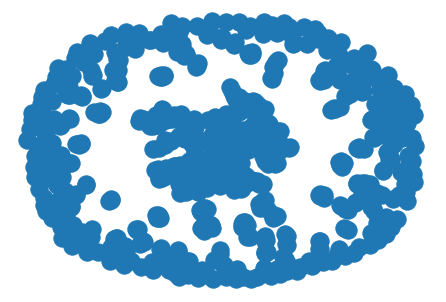

In [3]:
nx.draw(mlst_graph)

In [4]:
ST_info = pd.read_csv("../../supplementary_file_8/output/Genome_ST_info.csv")

Nodes 1-236 are pubMLST STs, the rest are not

In [5]:
pubmlst_degrees = [mlst_graph.degree[str(_)] for _ in range(1,238)]
new_degrees = [mlst_graph.degree[str(_)] for _ in range(238, len(mlst_graph.nodes())+1)]

<AxesSubplot:ylabel='Count'>

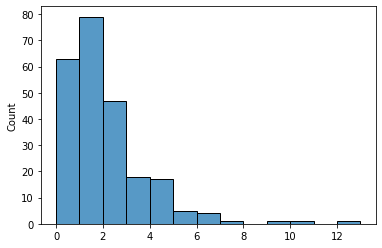

In [6]:
# Plot probability densities for each degree set
sns.histplot(np.array(pubmlst_degrees), binwidth=1)

In [9]:
from collections import Counter
Counter(pubmlst_degrees)

Counter({2: 47,
         6: 4,
         9: 1,
         7: 1,
         13: 1,
         1: 79,
         0: 63,
         3: 18,
         5: 5,
         4: 17,
         10: 1})

<AxesSubplot:ylabel='Count'>

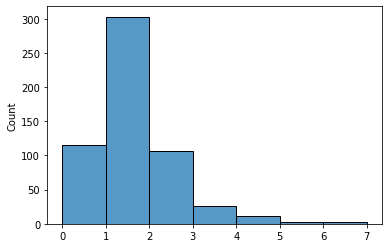

In [7]:
sns.histplot(np.array(new_degrees), binwidth=1)

In [10]:
Counter(new_degrees)

Counter({1: 303, 0: 115, 4: 12, 2: 107, 3: 26, 6: 1, 5: 3, 7: 1})

In [8]:
threshold = sum([_ >= 7 for _ in pubmlst_degrees])
print(f"{threshold=}")

def resample_graph(gph, n_nodes = 237, threshold=7):
    nodes = random.sample(gph.nodes(), n_nodes)
    degrees = [mlst_graph.degree[str(_)] for _ in nodes]
    return sum([_ >= threshold for _ in degrees])

tries = int(1e6)
resampled = [resample_graph(mlst_graph, threshold=7) for _ in tqdm(range(tries))]
print(sum([_ >= threshold for _ in resampled]) / tries)

threshold=4


  0%|          | 0/1000000 [00:00<?, ?it/s]

/var/folders/q5/_y5sk7t54698g_zl8yghqkmc0000gn/T/ipykernel_73899/4042806830.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes = random.sample(gph.nodes(), n_nodes)


0.02823


In [11]:
represented_STs = list(set([str(_) for _ in ST_info['ST']]))

In [12]:
not_represented_STs = [_ for _ in range(1,238) if str(_) not in represented_STs]

In [13]:
represented_degrees = [mlst_graph.degree[str(_)] for _ in represented_STs]
not_represented = [mlst_graph.degree[str(_)] for _ in not_represented_STs]

<AxesSubplot:ylabel='Count'>

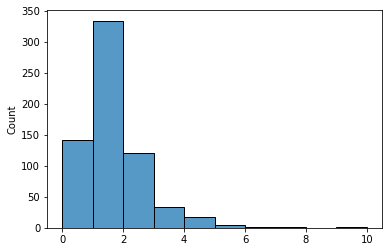

In [14]:
# Plot probability densities for each degree set
sns.histplot(np.array(represented_degrees), binwidth=1)

In [16]:
from collections import Counter

Counter(sorted(not_represented))

Counter({0: 36, 1: 48, 2: 34, 3: 11, 4: 12, 5: 3, 6: 3, 7: 1, 9: 1, 13: 1})

In [17]:
Counter(sorted(represented_degrees))

Counter({0: 142, 1: 334, 2: 120, 3: 33, 4: 17, 5: 5, 6: 2, 7: 1, 10: 1})

<AxesSubplot:ylabel='Count'>

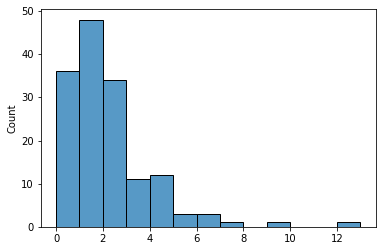

In [14]:
# Plot probability densities for each degree set
sns.histplot(np.array(not_represented), binwidth=1)

In [15]:
threshold = sum([_ >= 6 for _ in not_represented])
print(f"{threshold=}")


def resample_graph(gph, n_nodes = 150, threshold=6):
    nodes = random.sample(gph.nodes(), n_nodes)
    degrees = [mlst_graph.degree[str(_)] for _ in nodes]
    return sum([_ >= threshold for _ in degrees])

tries = int(1e6)
resampled = [resample_graph(mlst_graph, threshold=6) for _ in tqdm(range(tries))]
print(sum([_ >= threshold for _ in resampled]) / tries)

threshold=6


  0%|          | 0/1000000 [00:00<?, ?it/s]

/var/folders/q5/_y5sk7t54698g_zl8yghqkmc0000gn/T/ipykernel_46155/496668246.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  nodes = random.sample(gph.nodes(), n_nodes)


0.004196


When interpreting empirical tests like this, we have some advantages that we can use to justify our choice:

- the underlying structure of the data (the graph we're sampling from) is the _real_ data: we are not inappropriately assuming an idealised or parametric distribution, like Normal/Poisson, etc.
- we do not have to rely on estimators for parametric distributions, like means, standard deviations, etc. - we can instead measure exactly the property we care about. Here, that's the overabundance of high-degree nodes.
- we can express our analysis concisely and precisely: the code in the two cells above describes everything about the analysis

Here, we can tell the reader that we are _randomly resampling the same number of nodes as the pubMLST data_ from the _same underlying graph_ and estimating how frequently we would expect to see _the same number of high-degree (>=7) nodes or greater, at random.

Our value here of ≈0.025 is an empirical, non-parametric P-value of 0.025 and would be interpreted in the same way. 97.5% of the time, we would expect a _random selection of the same number of nodes_ from _the same underlying graph structure_ not to have at least as many high degree nodes. We can treat this like the P-value in a t-test. Our null hypothesis is that whatever random set of the same size we take, we're likely to see at least as many high-degree nodes; here, at a threshold of P=0.05, we would reject that hypothesis.